/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(s

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter 


Cross-Validation Results:
 Fold  Accuracy  Precision   Recall  F1 Score
    1  0.756757   0.658576 0.756757  0.688767
    2  0.702703   0.655688 0.702703  0.643525
    3  0.690909   0.756587 0.690909  0.690359
    4  0.645455   0.700595 0.645455  0.572724
    5  0.618182   0.494095 0.618182  0.522676

Mean Accuracy: 0.6828 ± 0.0536
Mean Precision: 0.6531 ± 0.0978
Mean Recall: 0.6828 ± 0.0536
Mean F1 Score: 0.6236 ± 0.0740

Class-wise Metrics (Last Fold):
 Class  Precision   Recall  F1 Score
c-CS-m   1.000000 0.444444  0.615385
c-CS-s   0.500000 1.000000  0.666667
c-SC-m   0.785714 0.916667  0.846154
c-SC-s   0.937500 0.937500  0.937500
t-CS-m   0.441860 0.904762  0.593750
t-CS-s   0.000000 0.000000  0.000000
t-SC-m   0.714286 1.000000  0.833333
t-SC-s   0.000000 0.000000  0.000000


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


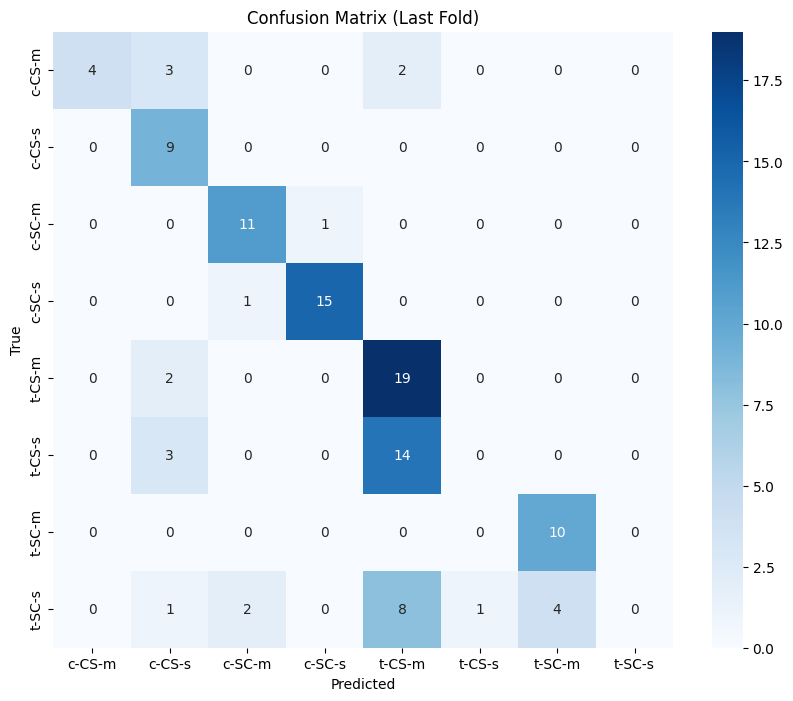

In [1]:
# Layer number increased, class weight added.
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

data = pd.read_csv('Data_Cortex_Nuclear.csv')

data = data.dropna()

numeric_columns = data.select_dtypes(include=[np.number]).columns
X = data[numeric_columns].values
y = data['class'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(enumerate(class_weights))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = []

for fold, (train_index, test_index) in enumerate(kf.split(X_reshaped), 1):
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

    model = Sequential([
        Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_reshaped.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(y_categorical.shape[1], activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0, class_weight=class_weight_dict)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

    fold_metrics.append({
        'Fold': fold,
        'Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

fold_metrics_df = pd.DataFrame(fold_metrics)
print("\nCross-Validation Results:")
print(fold_metrics_df.to_string(index=False))
print(f"\nMean Accuracy: {fold_metrics_df['Accuracy'].mean():.4f} ± {fold_metrics_df['Accuracy'].std():.4f}")
print(f"Mean Precision: {fold_metrics_df['Precision'].mean():.4f} ± {fold_metrics_df['Precision'].std():.4f}")
print(f"Mean Recall: {fold_metrics_df['Recall'].mean():.4f} ± {fold_metrics_df['Recall'].std():.4f}")
print(f"Mean F1 Score: {fold_metrics_df['F1 Score'].mean():.4f} ± {fold_metrics_df['F1 Score'].std():.4f}")

precision_per_class = precision_score(y_test_classes, y_pred_classes, average=None)
recall_per_class = recall_score(y_test_classes, y_pred_classes, average=None)
f1_per_class = f1_score(y_test_classes, y_pred_classes, average=None)

metrics_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1 Score': f1_per_class
})
print("\nClass-wise Metrics (Last Fold):")
print(metrics_df.to_string(index=False))

cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Last Fold)')
plt.show()